This is an illustrative example of how to integrate PiShield into a neural network to use it at training time for tabular data generation.
The code uses as starting point the [GAN tutorial](https://lightning.ai/docs/pytorch/2.1.0/notebooks/lightning_examples/basic-gan.html) of pytorch-lightning. 

For the real-world application of PiShield to synthesizing tabular data, please see the example in `PiShield/examples/tabular_data_generation/realistic_tabular_data_generation/`.

# A simple example first

**Requirement**: For a clinical trial dataset, we know that the maximum haemoglobin level should be at least as high as the minimum haemoglobin level recorded, for each patient.

**Task**: train a neural network to synthesise new data which satisfies this requirement!
     

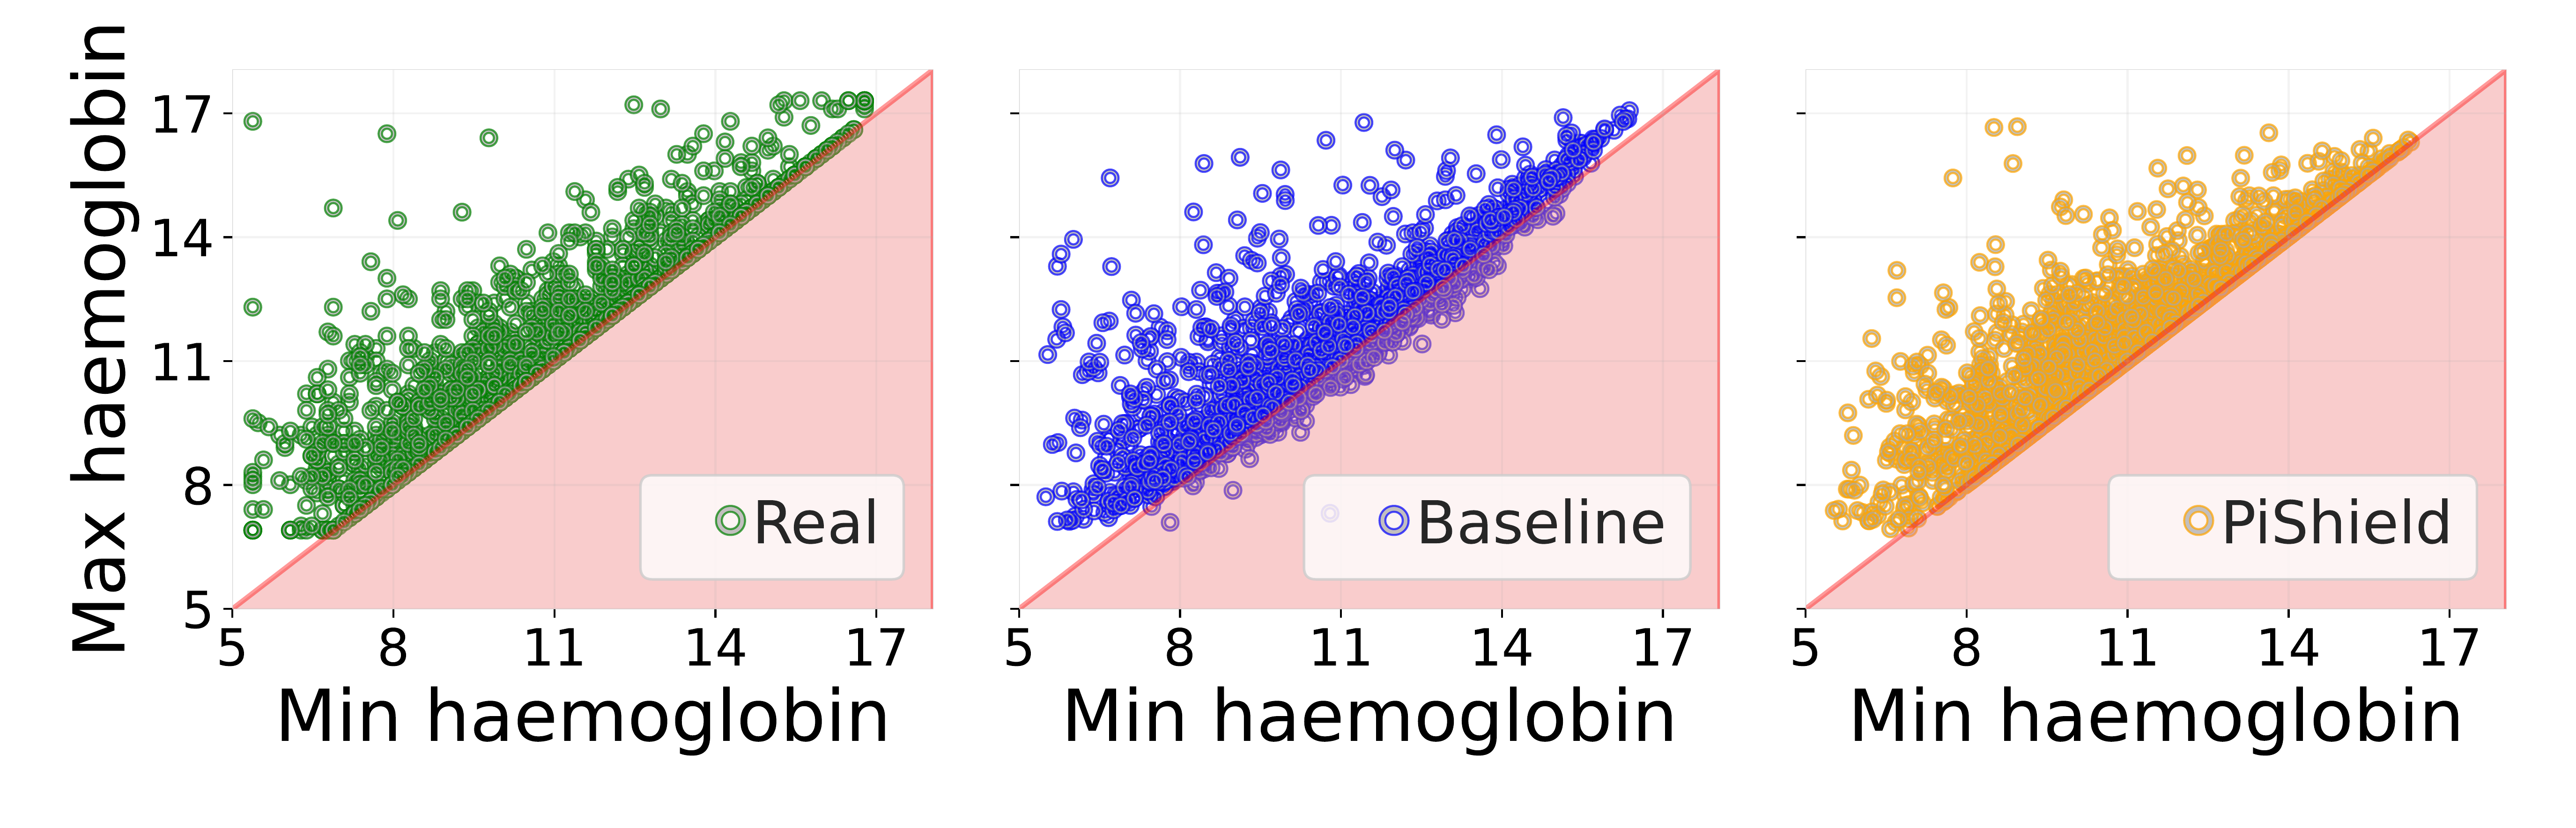

In [17]:
from IPython.display import Image
Image(filename='tabgen_example.png')

### Dependencies

In [18]:
# To run this notebook the following are needed: pandas,  pytorch-lightning, scikit-learn
! pip install pandas pytorch-lightning scikit-learn

In [19]:
# from pathlib import Path
# 
# current_path = !pwd
# current_path = current_path[0]
# src_path = "/".join(Path(current_path).parts[:-2])[1:]
# print(src_path)
# 
# ! cd $src_path ; pwd ; pip install .
# ! pwd

In [20]:
import os
import sys

import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from pishield.shield_layer import build_shield_layer
from pishield.linear_requirements.utils import check_constraint_satisfaction


In [21]:
PATH_DATASETS = '../../../data/linear_requirements/faults/'
PATH_REQUIREMENTS = f'{PATH_DATASETS}/constraints.txt'
BATCH_SIZE = 512 if torch.cuda.is_available() else 128
IS_REGRESSION_DATASET = False
NUM_WORKERS = int(os.cpu_count() / 2)

# The requirements
The requirements can be written in a simple `.txt` file.

In [22]:
! cat $PATH_REQUIREMENTS | tail -n +2

y_0 >= 0
y_1 - y_0 > 0
y_3 - y_2 > 0
y_9 - y_8 > 0
y_7 - y_9 > 0


### Data Preparation

In [23]:
class TabularDataTransformer():
    def __init__(self, csv_filename: str) -> None:
        
        super().__init__()
        self.cat_cols_names, self.bin_cols_idx, self.roundable_idx, self.round_digits = self._load_data(csv_filename)
    
    
    @staticmethod
    def get_round_decimals(col):
        MAX_DECIMALS = sys.float_info.dig - 1
        if (col == col.round(MAX_DECIMALS)).all():
            for decimal in range(MAX_DECIMALS + 1):
                if (col == col.round(decimal)).all():
                    return decimal
                
    def get_roundable_data(self, df):
        _is_roundable = ((df%1)==0).all(axis=0)
        roundable_cols = df.columns[_is_roundable]
        roundable_idx = [df.columns.get_loc(c) for c in roundable_cols]
        round_digits = df.iloc[:,roundable_idx].apply(self.get_round_decimals)
        return roundable_idx, round_digits


    @staticmethod
    def single_value_cols(df):
        a = df.to_numpy()
        single_value = (a[0] == a).all(0)
        return df.columns[single_value].to_list()

    
    def _load_data(self, csv_filename, manual_inspection_cat_cols_idx=None):
        if manual_inspection_cat_cols_idx is None:
            manual_inspection_cat_cols_idx = []
        data = pd.read_csv(csv_filename)
        single_val_col = self.single_value_cols(data)
        roundable_idx, round_digits = self.get_roundable_data(data)
    
        cat_cols_names = data.columns[manual_inspection_cat_cols_idx].values.tolist()
        for col in single_val_col:
            try:
                cat_cols_names.remove(col)
            except Exception as e:
                pass
        bin_cols_idx = [data.columns.get_loc(c) for c in cat_cols_names if c in data]
        roundable_idx = [i for i in roundable_idx if i not in bin_cols_idx]
        round_digits = round_digits[data.columns[roundable_idx]]
    
        if len(bin_cols_idx) == 0:
            bin_cols_idx = None
            cat_cols_names = None
        return cat_cols_names, bin_cols_idx, roundable_idx, round_digits
    
    def fit(self, csv_filename):
        data = pd.read_csv(csv_filename)
        min_observed = torch.tensor(data.min(axis=0).to_numpy(), dtype=torch.float32)
        max_observed = torch.tensor(data.max(axis=0).to_numpy(), dtype=torch.float32)
        
        scaler = StandardScaler()
        scaler.fit(data)
        means = scaler.mean_
        stds = scaler.scale_

        self._min_value = min_observed
        self._max_value = max_observed
        self.all_means = means
        self.all_stds = stds


    

In [24]:
class CustomTransformer(TabularDataTransformer):
    def __init__(self, csv_filename: str, enforce_min_max_values=True, regression=False):
        super().__init__(csv_filename)
        self.regression = regression
        self.enforce_min_max_values = enforce_min_max_values
        
    def set_means_and_stds(self):
        if self.regression:
            self.means = torch.tensor(self.all_means, dtype=torch.float32)
            self.stds = torch.tensor(self.all_stds, dtype=torch.float32)
        else:
            self.means = torch.cat([torch.tensor(self.all_means[:-1], dtype=torch.float32),
                                    torch.tensor([0.], dtype=torch.float32)])  # add 0 at the end for the target class
            self.stds = torch.cat([torch.tensor(self.all_stds[:-1], dtype=torch.float32),
                                   torch.tensor([1.], dtype=torch.float32)])  # add 1 at the end for the target class

    def fit(self, csv_filename):
        super().fit(csv_filename)
        self.set_means_and_stds()

    def transform(self, x: torch.Tensor) -> torch.Tensor:
        transformed_x = (x - self.means) / self.stds
        return transformed_x

    def inverse_transform(self, z: torch.Tensor, inference_time_enforce_min_max_values=True) -> torch.Tensor:
        inverse_transformed_z = z * self.stds + self.means
        if self.enforce_min_max_values or inference_time_enforce_min_max_values:
            inverse_transformed_z = inverse_transformed_z.clamp(self._min_value, self._max_value)
        return inverse_transformed_z

### Model

In [25]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_dim):
        super().__init__()
        self.num_dim = num_dim

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(num_dim)),
            nn.Tanh(),
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), self.num_dim)
        return img


In [26]:
class Discriminator(nn.Module):
    def __init__(self, num_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(num_dim), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [27]:
class GANLightningModuleNet(pl.LightningModule):
    def __init__(
        self,
        num_dim,
        data_transformer,
        constrained,
        latent_dim: int = 100,
        lr: float = 0.0002,
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = BATCH_SIZE,
        **kwargs,
    ):
        super().__init__()
        self.data_transformer = data_transformer
        self.constrained = constrained
        self.save_hyperparameters()
        self.automatic_optimization = False

        # networks
        self.generator = Generator(latent_dim=self.hparams.latent_dim, num_dim=num_dim)
        self.discriminator = Discriminator(num_dim=num_dim)
        
        #################################### Compile your requirements into a PiShield Layer
        self.CL = build_shield_layer(num_variables=num_dim, requirements_filepath=PATH_REQUIREMENTS)
        self.constraints = self.CL.constraints
        

    def forward(self, z):
        generated_data = self.generator(z)
        if self.constrained:
            inv_transf_gen_data = self.data_transformer.inverse_transform(generated_data.clone()) # map back to feature space
            
            #################################### Apply PiShield to correct your outputs
            corrected_data = self.CL(inv_transf_gen_data)
            ####################################
            
            print('Checking constraint satisfaction at epoch', self.current_epoch)
            check_constraint_satisfaction(corrected_data.clone(), self.constraints)
            generated_data = self.data_transformer.transform(corrected_data)  # map back to neural network space
        #################################### 
        else:
            print('Checking constraint satisfaction at epoch', self.current_epoch)
            check_constraint_satisfaction(self.data_transformer.inverse_transform(generated_data.clone()), self.constraints)
        
        return generated_data

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch):
        input = batch[0]

        optimizer_g, optimizer_d = self.optimizers()

        # sample noise
        z = torch.randn(input.shape[0], self.hparams.latent_dim)
        z = z.type_as(input)

        # train generator
        # generate images
        self.toggle_optimizer(optimizer_g)

        # ground truth result (ie: all fake)
        # put on GPU because we created this tensor inside training_loop
        valid = torch.ones(input.size(0), 1)
        valid = valid.type_as(input)

        # generate data
        generated_data = self(z)
        
        # adversarial loss is binary cross-entropy
        g_loss = self.adversarial_loss(self.discriminator(generated_data), valid)
        self.log("g_loss", g_loss, prog_bar=True)
        self.manual_backward(g_loss)
        optimizer_g.step()
        optimizer_g.zero_grad()
        self.untoggle_optimizer(optimizer_g)

        # train discriminator
        # Measure discriminator's ability to classify real from generated samples
        self.toggle_optimizer(optimizer_d)

        # how well can it label as real?
        valid = torch.ones(input.size(0), 1)
        valid = valid.type_as(input)

        real_loss = self.adversarial_loss(self.discriminator(input), valid)

        # how well can it label as fake?
        fake = torch.zeros(input.size(0), 1)
        fake = fake.type_as(input)

        # generate data
        generated_data = self(z)
        
        fake_loss = self.adversarial_loss(self.discriminator(generated_data.detach()), fake)

        # discriminator loss is the average of these
        d_loss = (real_loss + fake_loss) / 2
        self.log("d_loss", d_loss, prog_bar=True)
        self.manual_backward(d_loss)
        optimizer_d.step()
        optimizer_d.zero_grad()
        self.untoggle_optimizer(optimizer_d)

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

### Training preliminaries

In [28]:
transformer = CustomTransformer(f'{PATH_DATASETS}/train_data.csv', regression=IS_REGRESSION_DATASET)
transformer.fit(f'{PATH_DATASETS}/train_data.csv')

train_data = pd.read_csv(f'{PATH_DATASETS}/train_data.csv')
train_columns = train_data.columns
train_dtypes = train_data.dtypes

train_data = transformer.transform(torch.from_numpy(train_data.to_numpy().astype('float32')))
train_dataset = TensorDataset(train_data)
# train_dataset, val_dataset = random_split(train_dataset, [p1, p2])
# val_dataset, test_dataset = random_split(val_dataset, [p3, p4])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
num_dim = len(train_columns)


### Training without PiShield


In [29]:
model = GANLightningModuleNet(num_dim, transformer, constrained=False)
trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=5,
)
trainer.fit(model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 735 K 
1 | discriminator | Discriminator | 146 K 
2 | CL            | ShieldLayer   | 0     
------------------------------------------------
881 K     Trainable params
0         Non-trainable params
881 K     Total params
3.526     Total estimated model params size (MB)


Using auto mode ::: Detected linear requirements!
All constraints
 + y_0 >= 0.0
 + y_1 - y_0 > 0.0
 + y_3 - y_2 > 0.0
 + y_9 - y_8 > 0.0
 + y_7 - y_9 > 0.0


/home/mihian/software/miniconda3/envs/cloverd/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/mihian/software/miniconda3/envs/cloverd/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Checking constraint satisfaction at epoch 0
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 0
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 0
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 0
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 0
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 0
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 0
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 0
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 0
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 0
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 0
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 0
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 0
Not satisfied!  + y_

`Trainer.fit` stopped: `max_epochs=5` reached.


Checking constraint satisfaction at epoch 4
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 4
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 4
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 4
Not satisfied!  + y_3 - y_2 > 0.0
Checking constraint satisfaction at epoch 4
Not satisfied!  + y_3 - y_2 > 0.0


### Training with PiShield


In [30]:
model = GANLightningModuleNet(num_dim, transformer, constrained=True)
trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=5,
)
trainer.fit(model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 735 K 
1 | discriminator | Discriminator | 146 K 
2 | CL            | ShieldLayer   | 0     
------------------------------------------------
881 K     Trainable params
0         Non-trainable params
881 K     Total params
3.526     Total estimated model params size (MB)


Using auto mode ::: Detected linear requirements!
All constraints
 + y_0 >= 0.0
 + y_1 - y_0 > 0.0
 + y_3 - y_2 > 0.0
 + y_9 - y_8 > 0.0
 + y_7 - y_9 > 0.0


Training: |          | 0/? [00:00<?, ?it/s]

Checking constraint satisfaction at epoch 0
All constraints are satisfied!
Checking constraint satisfaction at epoch 0
All constraints are satisfied!
Checking constraint satisfaction at epoch 0
All constraints are satisfied!
Checking constraint satisfaction at epoch 0
All constraints are satisfied!
Checking constraint satisfaction at epoch 0
All constraints are satisfied!
Checking constraint satisfaction at epoch 0
All constraints are satisfied!
Checking constraint satisfaction at epoch 0
All constraints are satisfied!
Checking constraint satisfaction at epoch 0
All constraints are satisfied!
Checking constraint satisfaction at epoch 0
All constraints are satisfied!
Checking constraint satisfaction at epoch 0
All constraints are satisfied!
Checking constraint satisfaction at epoch 0
All constraints are satisfied!
Checking constraint satisfaction at epoch 0
All constraints are satisfied!
Checking constraint satisfaction at epoch 0
All constraints are satisfied!
Checking constraint satis

`Trainer.fit` stopped: `max_epochs=5` reached.


Checking constraint satisfaction at epoch 4
All constraints are satisfied!
Checking constraint satisfaction at epoch 4
All constraints are satisfied!
Checking constraint satisfaction at epoch 4
All constraints are satisfied!


# Other remarks
In this demo, we worked with simple constraints, but in our paper you can find more complex scenarios.

## 1. URL dataset

In [31]:
PATH_DATASETS_temp = '../../../data/linear_requirements/url/'
PATH_REQUIREMENTS_temp = f'{PATH_DATASETS_temp}/url_constraints.txt'
! cat $PATH_REQUIREMENTS_temp | tail -n +2 

y_0 - y_1 >= 0
y_0 - 3y_19 - y_3 - y_4 - y_5 - y_6 - y_7 - y_8 - y_9 - y_10 - y_11 - y_12 - y_13 - y_14 - y_15 - y_16 - y_17 >= 0
y_0 - 3y_20 - 4y_21 - 4y_22 - 2y_23 >= 0
y_37 - y_38 >= 0
y_0 - 3y_20 >= 1
y_0 - 4y_21 >= 1
y_0 - 4y_22 >= 1
y_0 - 2y_23 >= 1

## 2. Botnet dataset
Botnet contains:
* **757** features,
* **362** linear constraints,
* maximum number of features appearing in a single constraint **90**.

In [32]:
PATH_DATASETS_temp = '../../../data/linear_requirements/botnet/'
PATH_REQUIREMENTS_temp = f'{PATH_DATASETS_temp}/botnet_constraints.txt'
! cat $PATH_REQUIREMENTS_temp | tail -n +2 

y_17 + y_59 + y_101 + y_143 + y_185 + y_227 + y_269 + y_311 + y_353 + y_395 + y_437 + y_479 + y_521 + y_563 + y_605 + y_647 + y_689 + y_731 + y_16 + y_58 + y_100 + y_142 + y_184 + y_226 + y_268 + y_310 + y_352 + y_394 + y_436 + y_478 + y_520 + y_562 + y_604 + y_646 + y_688 + y_730 + y_15 + y_57 + y_99 + y_141 + y_183 + y_225 + y_267 + y_309 + y_351 + y_393 + y_435 + y_477 + y_519 + y_561 + y_603 + y_645 + y_687 + y_729 - y_0 - y_42 - y_84 - y_126 - y_168 - y_210 - y_252 - y_294 - y_336 - y_378 - y_420 - y_462 - y_504 - y_546 - y_588 - y_630 - y_672 - y_714 - y_3 - y_45 - y_87 - y_129 - y_171 - y_213 - y_255 - y_297 - y_339 - y_381 - y_423 - y_465 - y_507 - y_549 - y_591 - y_633 - y_675 - y_717 >= 0
-y_17 - y_59 - y_101 - y_143 - y_185 - y_227 - y_269 - y_311 - y_353 - y_395 - y_437 - y_479 - y_521 - y_563 - y_605 - y_647 - y_689 - y_731 - y_16 - y_58 - y_100 - y_142 - y_184 - y_226 - y_268 - y_310 - y_352 - y_394 - y_436 - y_478 - y_520 - y_562 - y_604 - y_646 - y_688 - y_730 - y_15 - 